# Note book to develop aerosol processing 
This note book tests all the aerosol processing code. It has been converted to a python script to be run after the um2nc_RNS.py, with the simple_um2 

It is specific to the file names generated by Sonya's UM RNS STASH pack... 

In [1]:
import sys
import os
import numpy as np
from datetime import datetime
import xarray as xr
import scipy.special

In [2]:
# some constants
Rd=287.05
cp=1005.46 # J/kg/K 1.0035
Rd_cp = Rd / cp
p0=1.0e5 # Pa
zboltz=1.3807e-23
avo=6.022e23
mm_da=avo*zboltz/Rd #molecular mass of dry air kg/mole

# Molecular masses (kgs/mol)
# n.b. mm_bc=0.012, mm_oc=mm_so=0.0168=1.4*mm_c. assume both primary & secondary organic species have mm=1.4*mm_c
mm_aer=[0.098,0.012,0.0168,0.05844,0.100,0.0168] 
cp_so4=0
cp_bc=1
cp_oc=2
cp_nacl=3
cp_du=4

# Functions for unit conversions

In [3]:
def calc_density(met):
    density = (met.air_pressure/(met.air_temperature*zboltz*1.0E6))
    return density

In [4]:
def gas_mmr_kgkg_to_ppb(chem): 
    if chem.mass_fraction_of_dimethyl_sulfide_in_air.attrs['units'] != 'kg kg-1': 
        print('chemical conversion already applied, units are:',chem.mass_fraction_of_dimethyl_sulfide_in_air.attrs['units'])
        return chem
    
    #MMRs
    if 'mass_fraction_of_dimethyl_sulfide_in_air' in chem.data_vars: 
        meta = chem['mass_fraction_of_dimethyl_sulfide_in_air'].attrs
        chem['mass_fraction_of_dimethyl_sulfide_in_air'] = chem['mass_fraction_of_dimethyl_sulfide_in_air']*((29./62.) * 1e9) # DMS 
        chem['mass_fraction_of_dimethyl_sulfide_in_air'] = chem['mass_fraction_of_dimethyl_sulfide_in_air'].assign_attrs(meta)
        chem['mass_fraction_of_dimethyl_sulfide_in_air'] = chem['mass_fraction_of_dimethyl_sulfide_in_air'].assign_attrs({'units':'ppb'})

    if 'mass_fraction_of_sulfur_dioxide_in_air' in chem.data_vars: 
        meta = chem['mass_fraction_of_sulfur_dioxide_in_air'].attrs
        chem['mass_fraction_of_sulfur_dioxide_in_air'] = chem['mass_fraction_of_sulfur_dioxide_in_air']*((29./64.) * 1e9) # SO2
        chem['mass_fraction_of_sulfur_dioxide_in_air'] = chem['mass_fraction_of_sulfur_dioxide_in_air'].assign_attrs(meta)
        chem['mass_fraction_of_sulfur_dioxide_in_air'] = chem['mass_fraction_of_sulfur_dioxide_in_air'].assign_attrs({'units':'ppb'})

    if 'mass_fraction_of_sulfuric_acid_in_air' in chem.data_vars: 
        meta = chem['mass_fraction_of_sulfuric_acid_in_air'].attrs
        chem['mass_fraction_of_sulfuric_acid_in_air'] = chem['mass_fraction_of_sulfuric_acid_in_air']*((29./98.) * 1e12) # gas phase H2SO4
        chem['mass_fraction_of_sulfuric_acid_in_air'] = chem['mass_fraction_of_sulfuric_acid_in_air'].assign_attrs(meta)
        chem['mass_fraction_of_sulfuric_acid_in_air'] = chem['mass_fraction_of_sulfuric_acid_in_air'].assign_attrs({'units':'ppt'})
    return chem

In [5]:
def aernumb_kg_to_cm3(aernumb,density): 
    if 'units' in aernumb.number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air.attrs: 
        print('aerosol number density conversion already applied, units are:',
              aernumb.number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air.attrs['units'])
        return aernumb
    
    # Number densities 
    for nd in ['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air',
               'number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air',
               'number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air',
               'number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air',
               'number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air']:
        meta = aernumb[nd].attrs
        aernumb[nd] = aernumb[nd] * density
        aernumb[nd] = aernumb[nd].assign_attrs(meta)
        aernumb[nd] = aernumb[nd].assign_attrs({'units':'cm-3'})
    return aernumb

In [6]:
def aermass_kgkg_to_molcm3(aermass,density): 
    if aermass.mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.attrs['units'] != 'kg kg-1': 
        print('aerosol mass conversion already applied, units are:',
              aermass.mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air.attrs['units'])
        return aermass    
        
    # Mass desnsities
    # H2SO4   
    for md in ['mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air',
               'mass_fraction_of_sulfuric_acid_in_soluble_aitken_mode_dry_aerosol_in_air',
               'mass_fraction_of_sulfuric_acid_in_soluble_accumulation_mode_dry_aerosol_in_air',
               'mass_fraction_of_sulfuric_acid_in_soluble_coarse_mode_dry_aerosol_in_air']:
        meta = aermass[md].attrs
        aermass[md] = aermass[md]*mm_da*(1/mm_aer[cp_so4])*(density/avo) #: kg/kg * kg/mol * mol/kg * mol/cm3
        aermass[md] = aermass[md].assign_attrs(meta)
        aermass[md] = aermass[md].assign_attrs({'units':'mol/cm-3'})

    # Organics
    for md in ['mass_fraction_of_particulate_organic_matter_in_soluble_nucleation_mode_dry_aerosol_in_air',
               'mass_fraction_of_particulate_organic_matter_in_soluble_aitken_mode_dry_aerosol_in_air',
               'mass_fraction_of_particulate_organic_matter_in_insoluble_aitken_mode_dry_aerosol_in_air',
               'mass_fraction_of_particulate_organic_matter_in_soluble_accumulation_mode_dry_aerosol_in_air',
               'mass_fraction_of_particulate_organic_matter_in_soluble_coarse_mode_dry_aerosol_in_air']:
        meta = aermass[md].attrs
        aermass[md] = aermass[md] * mm_da*(1/mm_aer[cp_oc])*(density/avo)
        aermass[md] = aermass[md].assign_attrs(meta)
        aermass[md] = aermass[md].assign_attrs({'units':'mol/cm-3'})

    # Sea salt
    for md in ['mass_fraction_of_seasalt_in_soluble_accumulation_mode_dry_aerosol_in_air',
               'mass_fraction_of_seasalt_in_soluble_coarse_mode_dry_aerosol_in_air']:
        meta = aermass[md].attrs
        aermass[md] = aermass[md] * mm_da*(1/mm_aer[cp_nacl])*(density/avo)
        aermass[md] = aermass[md].assign_attrs(meta)
        aermass[md] = aermass[md].assign_attrs({'units':'mol/cm-3'})

    # Black Carbon
    for md in ['mass_fraction_of_black_carbon_in_soluble_aitken_mode_dry_aerosol_in_air',
               'mass_fraction_of_black_carbon_in_soluble_accumulation_mode_dry_aerosol_in_air',
               'mass_fraction_of_black_carbon_in_soluble_coarse_mode_dry_aerosol_in_air',
               'mass_fraction_of_black_carbon_in_insoluble_aitken_mode_dry_aerosol_in_air']:
        meta = aermass[md].attrs
        aermass[md] = aermass[md] * mm_da*(1/mm_aer[cp_bc])*(density/avo)
        aermass[md] = aermass[md].assign_attrs(meta)
        aermass[md] = aermass[md].assign_attrs({'units':'mol/cm-3'}) 
        
    return aermass

In [7]:
def dust_kgkg_to_molcm3(dust,density): 
    if dust.mass_fraction_of_dust_ukmo_division_1_dry_aerosol_in_air.attrs['units'] != 'kg/kg': 
        print('dust conversion already applied, units are:',
            dust.mass_fraction_of_dust_ukmo_division_1_dry_aerosol_in_air.attrs['units'])
        return dust   
        
    # Dust 
    for md in ['mass_fraction_of_dust_ukmo_division_1_dry_aerosol_in_air',
               'mass_fraction_of_dust_ukmo_division_2_dry_aerosol_in_air',
               'mass_fraction_of_dust_ukmo_division_3_dry_aerosol_in_air',
               'mass_fraction_of_dust_ukmo_division_4_dry_aerosol_in_air',
               'mass_fraction_of_dust_ukmo_division_5_dry_aerosol_in_air',
               'mass_fraction_of_dust_ukmo_division_6_dry_aerosol_in_air']:
        meta = dust[md].attrs
        dust[md] = dust[md] * mm_da*(1/mm_aer[cp_du])*(density/avo)
        dust[md] = dust[md].assign_attrs(meta)
        dust[md] = dust[md].assign_attrs({'units':'mol/cm-3'})    
        
    return dust

# Functions for Nd concentrations

In [8]:
def lognormal_cumulative_to_r(N,radius,rbar,sigma):

    total_to_r=(N/2.0)*(1.0+scipy.special.erf(np.log(radius/rbar)/np.sqrt(2.0)/np.log(sigma)))

    return total_to_r

In [9]:
def cutoff_calcs(aernumb,aerdiam,size_radius,CCN):
    nsteps = len(aernumb.time)
    nmodes = 7
    nlevels=len(aernumb['level_height'])
    nlat = len(aernumb['grid_latitude'])
    nlon = len(aernumb['grid_longitude'])
    numb = np.zeros((nmodes,nsteps,nlevels,nlat,nlon))
    rbardry = np.zeros ((nmodes,nsteps,nlevels,nlat,nlon))
    sigma_g = [1.59,1.59,1.4,2.0,1.59,1.59,2.0]

    numb[0,:,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air.values[:,:,:,:] # Nuc
    numb[1,:,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air.values[:,:,:,:] # Ait
    numb[2,:,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air.values[:,:,:,:] # Acc
    numb[3,:,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air.values[:,:,:,:] # Coa
    if CCN==False: # Dont want to include in CCN calcs. 
        numb[4,:,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air.values[:,:,:,:]  # Ait Insol

    rbardry[0,:,:,:,:] = (aerdiam.dry_particle_diameter_soluble_nucleation_mode_aerosol.values[:,:,:,:] / 2)
    rbardry[1,:,:,:,:] = (aerdiam.dry_particle_diameter_soluble_aitken_mode_aerosol.values[:,:,:,:] / 2)
    rbardry[2,:,:,:,:] = (aerdiam.dry_particle_diameter_soluble_accumulation_mode_aerosol.values[:,:,:,:] / 2)
    rbardry[3,:,:,:,:] = (aerdiam.dry_particle_diameter_soluble_course_mode_aerosol.values[:,:,:,:] / 2)
    if CCN==False: # Dont want to include in CCN calcs. 
        rbardry[4,:,:,:,:] = (aerdiam.dry_particle_diameter_insoluble_aitken_mode_aerosol.values[:,:,:,:] / 2)

    for imode in range(5):
        
        nd_lt_d = lognormal_cumulative_to_r(numb[imode,:,:,:,:],size_radius,rbardry[imode,:,:,:,:], sigma_g[imode])
        nd_gt_d = numb[imode,:,:,:,:] - nd_lt_d
        
        if imode == 0: 
            Nd_tmp = nd_gt_d
        else: 
            Nd_tmp = Nd_tmp + nd_gt_d

    Nd = aernumb['number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air'].copy().to_dataset()
    Nd = Nd.rename({'number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air':'N{}'.format(int(size_radius*2e9))})
    if CCN==False: 
        Nd['N{}'.format(int(size_radius*2e9))] = Nd['N{}'.format(int(size_radius*2e9))].assign_attrs({'long_name':'Number of particles with dry diameter greater than {} nm per cm-3'.format(int(size_radius*2e9))}) 
    else:
        Nd['N{}'.format(int(size_radius*2e9))] = Nd['N{}'.format(int(size_radius*2e9))].assign_attrs({'long_name':'Number of soluble particles with dry diameter greater than {} nm per cm-3'.format(int(size_radius*2e9))}) 
    Nd['N{}'.format(int(size_radius*2e9))].values = Nd_tmp
    Nd['N{}'.format(int(size_radius*2e9))] = Nd['N{}'.format(int(size_radius*2e9))].assign_attrs({'Note':'These number concentrations have been calculated from the model output, may differ slightly from number concentrations calculated online by model'})

    del(Nd_tmp,rbardry,numb)

    return Nd

# Functions for size distributions

In [10]:
def lognormal_dndlogd(n,d,dbar,sigma_g):

    # evaluates lognormal distribution dn/dlogd at diameter d
    # dndlogd is the differential wrt the base10 logarithm

    xpi = 3.14159265358979323846e0

    numexp = -(np.log(d)-np.log(dbar))**2.0
    denomexp = 2.0*np.log(sigma_g)*np.log(sigma_g)

    denom = np.sqrt(2.0*xpi)*np.log(sigma_g)

    dndlnd = (n/denom)*np.exp(numexp/denomexp)

    dndlogd = 2.303*dndlnd

    return dndlogd

In [11]:
def generate_size_dists(aernumb,aerdiam):
    # Note - will only calc size dist at surface. 
    
    nsteps = len(aernumb.time)
    nlat = len(aernumb['grid_latitude'])
    nlon = len(aernumb['grid_longitude'])
    nmodes = 5
    numb = np.zeros((nmodes,nsteps,nlat,nlon))
    dbardry = np.zeros ((nmodes,nsteps,nlat,nlon))
    sigma_g = [1.59,1.59,1.4,2.0,1.59,1.59,2.0]
    npts = 50 # number of bins into which interpolate modal output

    # Organise model data 
    numb[0,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air.values[:,0,:,:] # Nuc
    numb[1,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air.values[:,0,:,:] # Ait
    numb[2,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air.values[:,0,:,:] # Acc
    numb[3,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air.values[:,0,:,:] # Coa
    numb[4,:,:,:] = aernumb.number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air.values[:,0,:,:]  # Ait Insol

    dbardry[0,:,:,:] = (aerdiam.dry_particle_diameter_soluble_nucleation_mode_aerosol.values[:,0,:,:])
    dbardry[1,:,:,:] = (aerdiam.dry_particle_diameter_soluble_aitken_mode_aerosol.values[:,0,:,:])
    dbardry[2,:,:,:] = (aerdiam.dry_particle_diameter_soluble_accumulation_mode_aerosol.values[:,0,:,:])
    dbardry[3,:,:,:] = (aerdiam.dry_particle_diameter_soluble_course_mode_aerosol.values[:,0,:,:])
    dbardry[4,:,:,:] = (aerdiam.dry_particle_diameter_insoluble_aitken_mode_aerosol.values[:,0,:,:])
    
    # determine which modes are active
    mode = np.zeros((nmodes),dtype=bool)
    for imode in range(nmodes):
        mode[imode] = np.isfinite(numb[imode,:].any()) # if any data in array, mode is active
    
    # define points for calculating size distribution
    rmin = 1.0e-9
    rmax = 1.0e-5
    dryr_mid = np.zeros(npts)
    dryr_int = np.zeros(npts+1)
    for ipt in range (npts+1):
        logr = np.log(rmin)+(np.log(rmax)-np.log(rmin))*float(ipt)/float(npts)
        dryr_int[ipt] = np.exp(logr)
    for ipt in range (npts):
        dryr_mid[ipt] = 10.0**(0.5*(np.log10(dryr_int[ipt+1])+np.log10(dryr_int[ipt]))) # in m
        
    dndlogd = np.zeros((nmodes,npts,nsteps,nlat,nlon)) # number densities for each mode
    dnd = np.zeros((npts,nsteps,nlat,nlon)) # number densities for total size dist (eg. sum of modes)

    for ipt in range (npts):
        for imode in range (nmodes):
            
            if (mode[imode]):
            
                dndlogd[imode,ipt,:,:,:] = lognormal_dndlogd(numb[imode,:,:,:],
                                                       dryr_mid[ipt]*2,
                                                       dbardry[imode,:,:,:],
                                                       sigma_g[imode])
            else:
                dndlogd[imode,ipt,:,:,:] = np.nan
                
        # Sum across all modes to get total size dist 
        dnd[ipt,:,:,:] = np.sum(dndlogd[:,ipt,:,:,:],axis=0)

    del(dndlogd) # don't need to keep this for now... save some memory 

    dryr_mid = dryr_mid*2.*1.0e9 # m to nm, radius to diameter
    sizedist = xr.DataArray(dnd,coords=[dryr_mid,aernumb.time,aernumb.grid_latitude,aernumb.grid_longitude],
                            dims=['dry_diameter','time','grid_latitude','grid_longitude']).to_dataset(name='sizedist')
    sizedist = sizedist.assign_coords({'latitude':aernumb.latitude})
    sizedist['sizedist'] = sizedist['sizedist'].assign_attrs({'Units':'dN / dlogD (cm-3)'})
    sizedist['dry_diameter'] = sizedist['dry_diameter'].assign_attrs({'Units':'nm'})
    return sizedist

# Read in data & apply conversions & overwrite. 

In [17]:
date = '20240101T0000Z'
fdir = '/scratch/jk72/slf563/UM_reg/output/di850/Regn1_resn_1_RAL3P2_glomap/{}/'.format(date)
hour = '024'
metfname = 'umnsaa_pmet{}_centralpoint.nc'.format(hour)
aermassfname = 'umnsaa_paermass{}_centralpoint.nc'.format(hour)
aernumbfname = 'umnsaa_paernumb{}_centralpoint.nc'.format(hour)
aerdiamfname = 'umnsaa_paerdiam{}_centralpoint.nc'.format(hour)
chemfname = 'umnsaa_pchem{}_centralpoint.nc'.format(hour)
dustfname = 'umnsaa_pdustmmrs{}_centralpoint.nc'.format(hour)


In [22]:
if os.path.exists(fdir+metfname):
    met = xr.open_dataset(fdir+metfname)
    density = calc_density(met)
    del(met)

if os.path.exists(fdir+chemfname):
    # Gas phase mass mixing ratios
    chem =  xr.open_dataset(fdir+chemfname)
    chem = gas_mmr_kgkg_to_ppb(chem)
    chem.to_netcdf(fdir+'tmp'+chemfname)
    os.replace(fdir+'tmp'+chemfname,fdir+chemfname)
    del(chem)

if os.path.exists(fdir+dustfname) and os.path.exists(fdir+metfname):
    # Dust mass mixing ratios 
    dust = xr.open_dataset(fdir+dustfname)
    dust = dust_kgkg_to_molcm3(dust,density)
    dust.to_netcdf(fdir+'tmp'+dustfname)
    os.replace(fdir+'tmp'+dustfname,fdir+dustfname)
    del(dust)

if os.path.exists(fdir+aermassfname) and os.path.exists(fdir+metfname):
    # Aerosol mass mixing ratios
    aermass = xr.open_dataset(fdir+aermassfname)
    aermass = aermass_kgkg_to_molcm3(aermass,density)
    aermass.to_netcdf(fdir+'tmp'+aermassfname)
    os.replace(fdir+'tmp'+aermassfname,fdir+aermassfname)
    del(aermass)

if os.path.exists(fdir+aernumbfname) and os.path.exists(fdir+metfname):
    # Aerosol number densities
    aernumb = xr.open_dataset(fdir+aernumbfname)
    aernumb = aernumb_kg_to_cm3(aernumb,density)
    aernumb.to_netcdf(fdir+'tmp'+aernumbfname)
    os.replace(fdir+'tmp'+aernumbfname,fdir+aernumbfname)

if os.path.exists(fdir+aerdiamfname):
    # Aerosol dry diameters 
    aerdiam = xr.open_dataset(fdir+aerdiamfname)

if os.path.exists(fdir+aerdiamfname) and os.path.exists(fdir+aernumbfname):
    # Calculate total number conc. at certain cut-offs
    N3 = cutoff_calcs(aernumb,aerdiam,1.5e-9,CCN=False)
    N10 = cutoff_calcs(aernumb,aerdiam,5e-9,CCN=False)
    CCN40 = cutoff_calcs(aernumb,aerdiam,20e-9,CCN=False)
    CCN50 = cutoff_calcs(aernumb,aerdiam,25e-9,CCN=False)
    aernumb_total_concentrations = xr.merge([N3,N10,CCN40,CCN50])
    aernumb_total_concentrations.to_netcdf(fdir+'umnsaa_paernumbtotals{}_centralpoint.nc'.format(hour))
    del(N3,N10,CCN40,CCN50,aernumb_total_concentrations)
    
    # Caluclate size distributions
    sizedist = generate_size_dists(aernumb,aerdiam)
    sizedist.to_netcdf(fdir+'umnsaa_psizedistributionssurf{}_centralpoint.nc'.format(hour))

    del(aerdiam,aernumb)

chemical conversion already applied, units are: ppb
dust conversion already applied, units are: mol/cm-3
aerosol mass conversion already applied, units are: mol/cm-3
aerosol number density conversion already applied, units are: cm-3


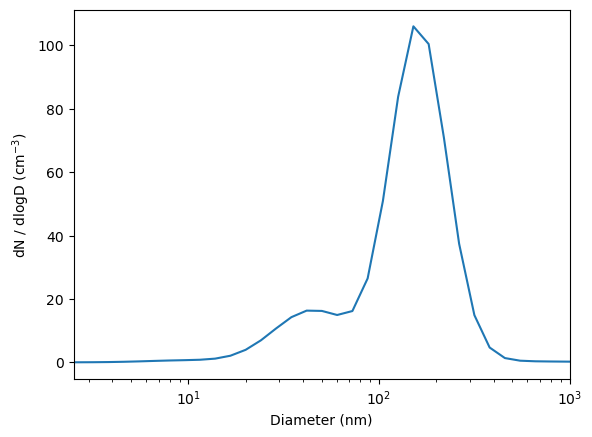

In [23]:
# Quick sanity check of size dists if needed. 
import matplotlib
import matplotlib.pyplot as plt

plt.semilogx(sizedist.dry_diameter,sizedist.sizedist.mean(dim=['time','grid_latitude','grid_longitude']));
    
#plt.ylim((0,500));
plt.xlim((2.5,1e3));
plt.xlabel('Diameter (nm)');
plt.ylabel('dN / dlogD (cm$^{-3}$)');